# Кластеризация текстов

In [16]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

In [17]:
# Выбираем 4 категории новостей для легковесности примера
categories = [
    'rec.sport.hockey', # хоккей
    'talk.politics.mideast', # политические новости о Ближнем Востоке
    'comp.graphics', # компьютерная графика
    'sci.crypt' # криптография
]

# Скачиваем набор данных
dataset = fetch_20newsgroups(subset='all', categories=categories,
                             shuffle=True, random_state=42)

print("%d документов" % len(dataset.data))
print("%d категории" % len(dataset.target_names))

# Записываем значения категорий для каждой новости
labels = dataset.target

3903 документов
4 категории


## Предобработка данных

In [18]:
# Исходный набор данных, первые 10 примеров
for i in range(10):
    print(dataset.data[i], end='\n' + '*' * 50 + '\n\n')

From: c5ff@jupiter.sun.csd.unb.ca (COOK  Charlie)
Subject: NHL Summary parse results for games played Mon, April 19, 1993
Organization: University of New Brunswick
Lines: 79

Toronto                          1 1 1--3
Detroit                          1 4 1--6
First period
     1, Detroit, Yzerman 1 (Gallant, Ciccarelli) 4:48.
     2, Toronto, Cullen 1 (Clark, Gill) 10:44.
Second period
     3, Detroit, Sheppard 1 (Probert, Coffey) pp, 5:04.
     4, Detroit, Burr 1 (Racine) sh, 6:42.
     5, Detroit, Chiasson 1 (Coffey) pp,11:00.
     6, Detroit, Howe 1 (Yzerman, Drake) 14:46.
     7, Toronto, Gilmour 1 (Borschevsky, Ellett) pp, 19:59.
Third period
     8, Detroit, Racine 1 (Primeau, Drake) 5:10.
     9, Toronto, Lefebvre 1 (Cullen, Pearson) 7:45.

Detroit: 6    Power play: 6-2   Special goals:  pp: 2  sh: 1  Total: 3
Scorer            G    A   Pts
---------------  ---  ---  ---
Burr               1    0    1
Chiasson           1    0    1
Ciccarelli         0    1    1
Coffey           

In [19]:
# Создаём объект, который будет токенизировать данные
analyzer = CountVectorizer(stop_words='english').build_analyzer()

# Токенизируем наш набор данных
docs = []
for document in dataset.data:
    docs.append(analyzer(document.replace('_', '')))

# И посмотрим 10 первых примеров
for i in range(10):
    print(docs[i], end='\n\n')

['c5ff', 'jupiter', 'sun', 'csd', 'unb', 'ca', 'cook', 'charlie', 'subject', 'nhl', 'summary', 'parse', 'results', 'games', 'played', 'mon', 'april', '19', '1993', 'organization', 'university', 'new', 'brunswick', 'lines', '79', 'toronto', 'detroit', 'period', 'detroit', 'yzerman', 'gallant', 'ciccarelli', '48', 'toronto', 'cullen', 'clark', 'gill', '10', '44', 'second', 'period', 'detroit', 'sheppard', 'probert', 'coffey', 'pp', '04', 'detroit', 'burr', 'racine', 'sh', '42', 'detroit', 'chiasson', 'coffey', 'pp', '11', '00', 'detroit', 'howe', 'yzerman', 'drake', '14', '46', 'toronto', 'gilmour', 'borschevsky', 'ellett', 'pp', '19', '59', 'period', 'detroit', 'racine', 'primeau', 'drake', '10', 'toronto', 'lefebvre', 'cullen', 'pearson', '45', 'detroit', 'power', 'play', 'special', 'goals', 'pp', 'sh', 'total', 'scorer', 'pts', 'burr', 'chiasson', 'ciccarelli', 'coffey', 'drake', 'gallant', 'howe', 'primeau', 'probert', 'racine', 'sheppard', 'yzerman', 'toronto', 'power', 'play', 'sco

In [20]:
# Проверим, что число документов осталось прежним
len(docs)

3903

## Векторизация текстов

In [21]:
# Установка пакета gensim
#!pip install -U gensim


In [22]:
from gensim.models import Word2Vec

# Обучаем модель векторайзера на нашем наборе данных
# На выходе мы получим вектор признаков для каждого слова
model = Word2Vec(docs, min_count=20, size=50)

# Наивный подход к созданию единого эмбеддинга для документа – средний эмбеддинг по словам
def doc_vectorizer(doc, model):
    doc_vector = []
    num_words = 0
    for word in doc:
        try:
            if num_words == 0:
                doc_vector = model[word]
            else:
                doc_vector = np.add(doc_vector, model[word])
            num_words += 1
        except:
            pass
     
    return np.asarray(doc_vector) / num_words

# Составляем эмбеддинги для наших документов
X = []
for doc in docs:
    X.append(doc_vectorizer(doc, model))

<ipython-input-22-57cd6b3a200b>:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  doc_vector = model[word]
<ipython-input-22-57cd6b3a200b>:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  doc_vector = np.add(doc_vector, model[word])


In [23]:
# Как выглядят первые 10 документов после векторизации 
X[:10]

[array([ 0.4666666 ,  0.260903  ,  0.5131864 ,  0.24948466,  0.9529041 ,
        -0.6800999 , -1.9971529 , -0.7465897 , -0.06149044,  0.8697335 ,
         0.40733078,  0.32289442,  0.5394204 ,  0.47399712,  0.4650116 ,
         0.07242729, -0.8207817 ,  0.69635165, -0.76047677, -0.3652948 ,
         0.48511097, -0.8534405 ,  0.43117362,  0.80895853, -0.1306668 ,
         0.26399556, -0.27602988,  0.1913398 , -0.24564384, -0.9780136 ,
         0.03588364,  0.49511218, -0.4172009 ,  0.70059395, -0.5823803 ,
        -0.09794306, -0.09172067, -0.2245182 ,  0.5574231 , -0.00828241,
        -0.19981173, -0.3393241 ,  0.3870746 , -0.26938462,  0.16707179,
        -0.35330126,  0.2617929 ,  0.5352476 , -0.886894  ,  0.24126463],
       dtype=float32),
 array([ 0.4573347 ,  0.10400604,  0.10924812, -0.23140681,  0.32489875,
        -0.54316986, -1.4433031 , -0.16139136, -0.08259348,  0.37048975,
         0.2435954 ,  0.39397582, -0.1344592 ,  0.4610394 , -0.0116651 ,
         0.09879402, -0.167

In [24]:
# Проверим размер вектора для документа
print(np.asarray(X).shape)

(3903, 50)


In [25]:
# t-SNE – метод понижения размерности
from sklearn.manifold import TSNE

# Создаём объект для выполнения t-SNE
tsne = TSNE(n_components=2, random_state=0)

# Преобразуем наши данные, понизив размерность с 50 до 2
X = tsne.fit_transform(X)

print(np.asarray(X).shape)

(3903, 2)


## Кластеризация

In [26]:
# Создаём KMeans кластеризатор 
kmeans = KMeans(n_clusters=4)

# Обучим кластеризатор на подготовленных данных
kmeans.fit(X)

KMeans(n_clusters=4)

In [27]:
# Получаем предсказанные кластеры
y_pred = kmeans.labels_.astype(np.int)

# Координаты полученных центроидов
print ("Координаты центроидов:\n", kmeans.cluster_centers_)

Координаты центроидов:
 [[ 48.052525     9.614969  ]
 [-13.397863    44.22159   ]
 [  0.06674433 -39.080517  ]
 [-35.51519     -4.8144727 ]]


In [28]:
# Метрики
print ("Коэффициент силуэта: %0.3f" % metrics.silhouette_score(X, y_pred, metric='euclidean'))
print("Однородность: %0.3f" % metrics.homogeneity_score(labels, y_pred))
print("Полнота: %0.3f" % metrics.completeness_score(labels, y_pred))
print("V-мера: %0.3f" % metrics.v_measure_score(labels, y_pred))

Коэффициент силуэта: 0.500
Однородность: 0.765
Полнота: 0.768
V-мера: 0.766


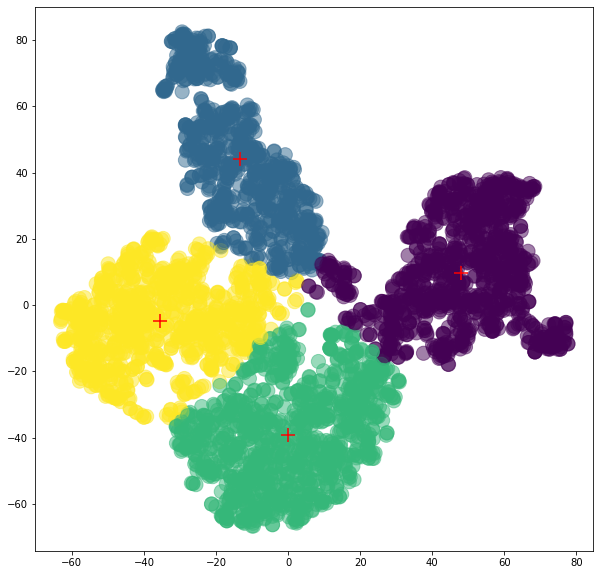

In [29]:
# Графики полученных кластеров
plt.rcParams['figure.figsize'] = 10, 10
plt.scatter(X[:, 0], X[:, 1], c=y_pred, s=200, alpha=.5)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=200, marker='+')
plt.show()

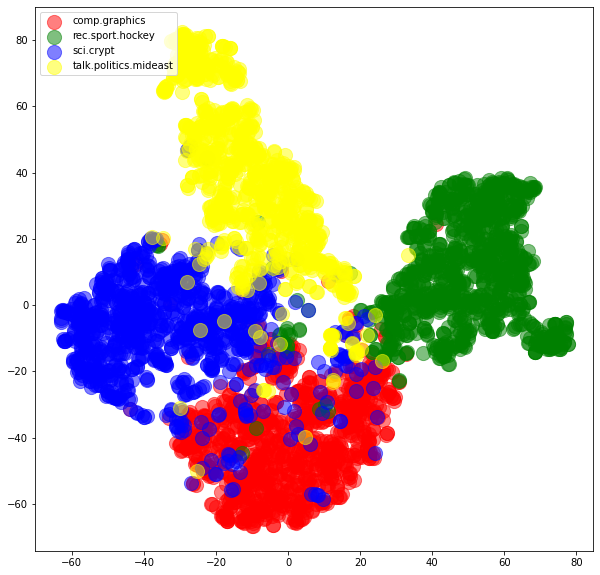

In [30]:
# Построим график истинных классов
colors = ("red", "green", "blue", "yellow")

for i in range(4):
    plt.scatter(X[labels==i][:, 0], X[labels==i][:, 1], \
                s=200, alpha=.5, c=colors[i], label=dataset.target_names[i])
    plt.legend(loc=2)

plt.show()